In [11]:
atac_dir = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/interpret/"
dnase_dir = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/interpret/"

atac_obs = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw"
dnase_obs = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/data/GM12878_unstranded.bw"

In [15]:
with_bias_preds = "GM12878_w_bias.bw"
without_bias_preds = "GM12878_wo_bias.bw"
interpretation_counts_f = "merged.GM12878.counts.bw"
interpretation_profile_f = "merged.GM12878.profile.bw"

peaks = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/filtered.peaks.bed"

In [16]:
import numpy as np
import pyBigWig
import pandas as pd


In [20]:
def get_cts(peaks_df, bw, width=1000):
    """
    Fetches values from a bigwig bw, given a df with minimally
    chr, start and summit columns. Summit is relative to start.
    Retrieves values of specified width centered at summit.

    "cts" = per base counts across a region
    """
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(np.nan_to_num(bw.values(r['chr'], 
                                            r['start'] + r['summit'] - width//2,
                                            r['start'] + r['summit'] + width//2)))
        
    return np.array(vals)    

In [18]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

peak_regions=pd.read_csv(peaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
bed_regions_to_keep=peak_regions[peak_regions["chr"].isin(["chr1"])]


In [21]:
atac_obs_bw = get_cts(bed_regions_to_keep, pyBigWig.open(atac_obs)) 
dnase_obs_bw = get_cts(bed_regions_to_keep, pyBigWig.open(dnase_obs))

atac_w_bias = get_cts(bed_regions_to_keep, pyBigWig.open(atac_dir + with_bias_preds))
dnase_w_bias = get_cts(bed_regions_to_keep, pyBigWig.open(dnase_dir + with_bias_preds))

atac_wo_bias = get_cts(bed_regions_to_keep, pyBigWig.open(atac_dir + without_bias_preds))
dnase_wo_bias = get_cts(bed_regions_to_keep, pyBigWig.open(dnase_dir + without_bias_preds))

atac_counts = get_cts(bed_regions_to_keep, pyBigWig.open(atac_dir + interpretation_counts_f))
dnase_counts = get_cts(bed_regions_to_keep, pyBigWig.open(dnase_dir + interpretation_counts_f))

atac_profile = get_cts(bed_regions_to_keep, pyBigWig.open(atac_dir + interpretation_profile_f))
dnase_profile = get_cts(bed_regions_to_keep, pyBigWig.open(dnase_dir + interpretation_profile_f))

In [36]:
from scipy.spatial.distance import jensenshannon

def do_min_max(v):
     return (v - v.min()) / (v.max() - v.min())
    
def get_jsd(bed_regions_to_keep, atac_vals, dnase_vals, min_max_normalize=False):
    jsd_vals = []
    for idx in range(bed_regions_to_keep.shape[0]):
        if min_max_normalize:
            jsd_vals.append(jensenshannon(do_min_max(atac_vals[idx]), do_min_max(dnase_vals[idx])))
        else:
            jsd_vals.append(jensenshannon(atac_vals[idx], dnase_vals[idx]))
    return jsd_vals
        


In [37]:
observed = get_jsd(bed_regions_to_keep, atac_obs_bw, dnase_obs_bw)
predicted = get_jsd(bed_regions_to_keep, atac_w_bias, dnase_w_bias)
corrected = get_jsd(bed_regions_to_keep, atac_wo_bias, dnase_wo_bias)
counts = get_jsd(bed_regions_to_keep, atac_counts, dnase_counts,min_max_normalize=True)
profile = get_jsd(bed_regions_to_keep, atac_profile, dnase_profile,min_max_normalize=True)

/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


In [44]:
d = {'jsd values': observed+predicted+corrected+counts+profile, 'atac versus dnase': ["observed"]*len(observed)+["predicted"]*len(predicted)+["corrected"]*len(corrected)+["counts"]*len(counts)+["profile"]*len(profile)}
df = pd.DataFrame(data=d)

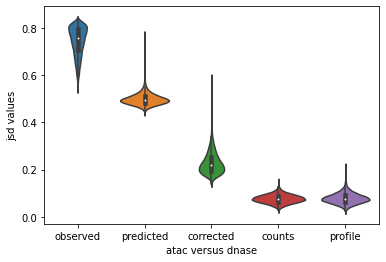

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.violinplot(x="atac versus dnase", y="jsd values", data=df)
plt.savefig("jsd_compare_k562.png")
